## Transfer Learning Tuning_EyeWear:
  * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 and freeze at bottleneck layer (stop right before flatten layer) 
  * top_model: tune dense layers (parameters are inspired by source)
     * batch_size 16 seems to work best for small data set 
     
  * extra blog source for callbacks and saving models:
  
  [call_backs for best weights](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)
  
  [saving models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

##### warnings: due to the order of my dataframe, the first entry is not_eyewear, class predict 1 == has no eyewear
  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0903 21:21:57.404081 140691783780160 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 21:21:57.405112 140691783780160 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
#### Import necessary libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [4]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess


%aimport vgg16_preprocess


---
#### Import train_df and test_df for eyewears

In [5]:
def load_df(label):
    '''
    label: eyewear,beard, or hat a string
    return train and test df 
    '''
    if label == 'eyewear':
        train_df = pd.read_pickle('../pickle_files/train_df_glasses.pkl')
        test_df = pd.read_pickle('../pickle_files/test_df_glasses.pkl')
    if label == 'beard':
        train_df = pd.read_pickle('../pickle_files/train_df_beard.pkl')
        test_df = pd.read_pickle('../pickle_files/test_df_beard.pkl')
    if label == 'hat':
        train_df = pd.read_pickle('../pickle_files/train_df_hat.pkl')
        test_df = pd.read_pickle('../pickle_files/test_df_hat.pkl')
    return train_df, test_df     

In [6]:
train_df, test_df = load_df('eyewear')
train_df.head()

,pic_id,eyewear
235,00964.jpg,not_eyewear
171,00872.jpg,not_eyewear
372,00412.jpg,eyewear
93,00745.jpg,not_eyewear
142,00822.jpg,not_eyewear


#### Get bottleneck features to tune top models

In [30]:
def save_bottleneck_features(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df, test_df: train and test dataframes saved in pickle_files folder
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the vgg16 model 
    # make sure not to train the top layers 
    base_model = VGG16(weights = 'imagenet', include_top = False)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range= [0.8,2],
        brightness_range=[0.8,1.2],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=vgg16_preprocess.preprocess_input
    ) # add reprocess to prevent overfitting 
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size
    )
    np.save(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_train_{label}_custom_preprocess_150.npy','wb'),
           bottleneck_features_train)
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),  # change to default input size 
    class_mode = None)
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_test_{label}_custom_preprocess_150.npy','wb'),
           bottleneck_features_test)

#### Save bottleneck_features

In [31]:
save_bottleneck_features(train_df,test_df,'eyewear',16)

Found 505 validated image filenames.
Found 127 validated image filenames.


### Quick tuning of top models 

In [32]:
def train_top_model(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes saved in pickle_files to generate train and test labels 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_train_{label}_custom_preprocess_150.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open(f'../tuning_data/VGG_16_tuning/bottleneck_features_test_{label}_custom_preprocess_150.npy','rb'))
    test_label = np.array(test_df[label].map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer= optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_{label}_custom_preprocess_150.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [33]:
train_top_model(train_df, test_df, 50, 16, 'eyewear')

Train on 496 samples, validate on 112 samples
Epoch 1/50
496/496 [==============================] - 0s 695us/step - loss: 1.0354 - acc: 0.5806 - val_loss: 0.5549 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to ../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_eyewear_custom_preprocess_150.h5
Epoch 2/50
496/496 [==============================] - 0s 220us/step - loss: 0.4837 - acc: 0.7984 - val_loss: 0.4663 - val_acc: 0.7679

Epoch 00002: val_acc improved from 0.75000 to 0.76786, saving model to ../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_eyewear_custom_preprocess_150.h5
Epoch 3/50
496/496 [==============================] - 0s 221us/step - loss: 0.3051 - acc: 0.8669 - val_loss: 0.4170 - val_acc: 0.8482

Epoch 00003: val_acc improved from 0.76786 to 0.84821, saving model to ../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_eyewear_custom_preprocess_150.h5
Epoch 4/50
496/496 [==============================] - 0s 220us/step -

496/496 [==============================] - 0s 224us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.6190 - val_acc: 0.8482

Epoch 00042: val_acc did not improve from 0.88393
Epoch 43/50
496/496 [==============================] - 0s 228us/step - loss: 7.0545e-04 - acc: 1.0000 - val_loss: 0.6170 - val_acc: 0.8482

Epoch 00043: val_acc did not improve from 0.88393
Epoch 44/50
496/496 [==============================] - 0s 231us/step - loss: 7.6556e-04 - acc: 1.0000 - val_loss: 0.6295 - val_acc: 0.8482

Epoch 00044: val_acc did not improve from 0.88393
Epoch 45/50
496/496 [==============================] - 0s 227us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6541 - val_acc: 0.8482

Epoch 00045: val_acc did not improve from 0.88393
Epoch 46/50
496/496 [==============================] - 0s 239us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6319 - val_acc: 0.8571

Epoch 00046: val_acc did not improve from 0.88393
Epoch 47/50
496/496 [==============================] - 0s 226us/step - los

### Fine Tune Top Model to improve accuracy

In [34]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_vgg = VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
    # build top model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights(f'../tuning_data/VGG_16_tuning/best_bottleneck_vgg16_model_{label}_custom_preprocess_150.h5')
    # add top model to model
    model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))
    # we will tune last 5 layers of the model: block5 and fully connected layer 
    for layer in model.layers[:15]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
        rescale=1./255,
        zoom_range= [0.8,2],
        brightness_range=[0.8,1.2],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=vgg16_preprocess.preprocess_input)
    # not want to augment the test 
    test_gen = ImageDataGenerator(
            rescale = 1./255,
            preprocessing_function=vgg16_preprocess.preprocess_input)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(150,150),
    class_mode = 'binary')
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/VGG_16_tuning/best_vgg_model_{label}_custom_preprocess_150_customsteps.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=25,
    verbose=1,
    callbacks=callbacks_list)
    
    if print_model:
        model.summary()
        
    del model
    keras.backend.clear_session()
    
    return result      

### save model history 

In [ ]:
model_history = fine_tune_model(train_df, test_df,40,16,'eyewear')

Found 505 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Epoch 1/40
100/100 [==============================] - 17s 165ms/step - loss: 1.0234 - acc: 0.4407 - val_loss: 0.6941 - val_acc: 0.5365

Epoch 00001: val_acc improved from -inf to 0.53652, saving model to ../tuning_data/VGG_16_tuning/best_vgg_model_eyewear_custom_preprocess_150_customsteps.h5
Epoch 2/40
100/100 [==============================] - 15s 148ms/step - loss: 0.6975 - acc: 0.5440 - val_loss: 0.6768 - val_acc: 0.5516

Epoch 00002: val_acc improved from 0.53652 to 0.55164, saving model to ../tuning_data/VGG_16_tuning/best_vgg_model_eyewear_custom_preprocess_150_customsteps.h5
Epoch 3/40
100/100 [==============================] - 15s 154ms/step - loss: 0.6740 - acc: 0.5842 - val_loss: 0.6542 - val_acc: 0.6045

Epoch 00003: val_acc improved from 0.55164 to 0.60453, saving model to ../tuning_data/VGG_16_tuning/best_vgg_model_eyewear_custom_preprocess_150_customstep

In [22]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9899244332493703
------------------
highest train accuracy: 1.0


In [23]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.07392854217712014
------------------
lowest train loss: 0.006984214529525158


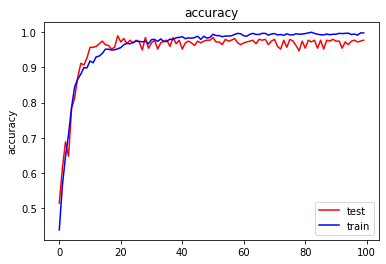

In [24]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

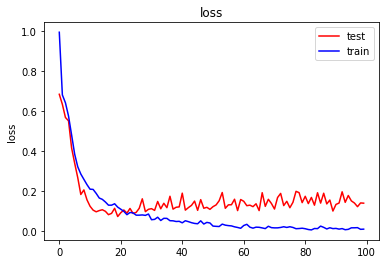

In [25]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

### Save model 

In [13]:
# save model artchitecture 
eyewear_model = model_history.model
eyewear_model_json = eyewear_model.to_json()

In [16]:
# serialize model to JSON
with open("../tuning_data/VGG_16_tuning/vgg16_model_custom_preprocess_150.json", "w") as json_file:
    json_file.write(eyewear_model_json)

### Model Testing

In [26]:
# load json and create model
def model_testing(model_path, weight_path, label):
    '''
    model_path: json model path
    weight_path: path for weights 
    label: eyewear, hat, or beard
    '''
    train_df, test_df = load_df(label)
    df = pd.concat([train_df,test_df])
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight 
    loaded_model.load_weights(weight_path)
    # test test data
    data_gen = ImageDataGenerator(1./255, preprocessing_function=vgg16_preprocess.preprocess_input)
    data_generator = data_gen.flow_from_dataframe(
        dataframe=df,
        directory='../data/pics',
        x_col='pic_id',
        y_col=label,
        batch_size=300,
        target_size=(150,150),
        class_mode = 'binary',
        shuffle = False
    )
    labels = df[label].map({f'not_{label}':1, f'{label}':0})
    
    loaded_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(),
             metrics=['accuracy']
                        )
    y_pred = np.around(loaded_model.predict_generator(data_generator, workers=8))
    fpr, tpr, thresholds = roc_curve(labels, y_pred)
    area = roc_auc_score(labels, y_pred)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(confusion_matrix(labels, y_pred))
    print(classification_report(labels, y_pred))    

### EyeWear

Found 632 validated image filenames belonging to 2 classes.


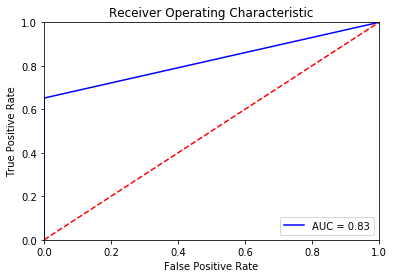

[[316   0]
 [110 206]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       316
           1       1.00      0.65      0.79       316

    accuracy                           0.83       632
   macro avg       0.87      0.83      0.82       632
weighted avg       0.87      0.83      0.82       632



In [27]:
model_testing('../tuning_data/VGG_16_tuning/vgg16_model_custom_preprocess_150.json',
             '../tuning_data/VGG_16_tuning/best_vgg_model_eyewear_custom_preprocess_150_customsteps.h5',
             'eyewear')